In [26]:
import sys
# setting path
sys.path.append('..')

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from src import io, var, utils, fourier, lin_reg, reconstruction
from vis import plotter

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)

importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

Setup objects and read data. Specify the extent of the lat-lon grid to be read in.

In [28]:
# initialise data objects
grid = var.grid()
topo = var.topo_cell()

# read grid
reader = io.ncdata()
fn = '../data/icon_compact.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg)

# read topography
fn = '../data/topo_compact.nc'
reader.read_dat(fn, topo)

# we only keep the topography that is inside this lat-lon extent.
lat_verts = np.array([52.,64.,64.])
lon_verts = np.array([-141.,-158.,-127.])

reader.read_topo(topo, topo, lon_verts, lat_verts)

Data fetched...


Plot the loaded topography...

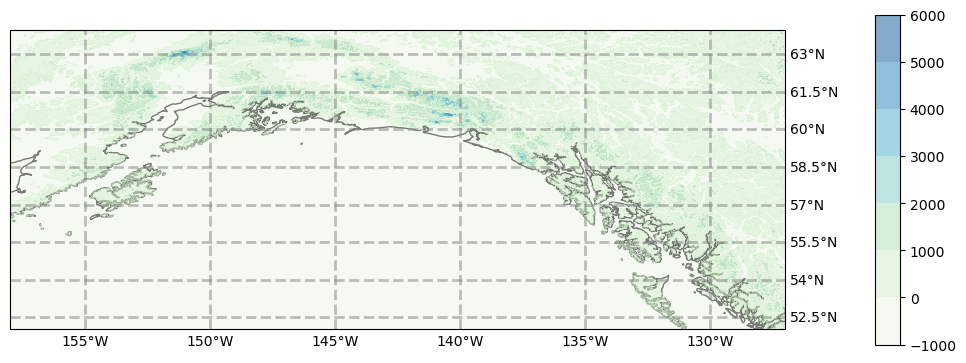

In [29]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

topo.gen_mgrids()

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
im = ax.contourf(topo.lon_grid, topo.lat_grid, topo.topo,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            cmap='GnBu',
            # vmin=0.0,
            # vmax=3000.0
            )

cax = fig.add_axes([0.99, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False

gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter(auto_hide=False)
gl.yformatter = LatitudeFormatter()

ax.tick_params(axis="both",
               tickdir='out',
               length=15,
               grid_transform=ccrs.PlateCarree())

plt.show()

In [30]:
# A = np.arange(100).reshape(10,10)
# print(A)


# B = np.array_split(A, 2)
# print(B)

print(cell.lat_grid.shape)

np.random.seed(100)
rand_lat_idx = np.random.randint(len(cell.lat), size=50)
rand_lon_idx = np.random.randint(len(cell.lon), size=50)

# print(rand_lat_idx)
# print(rand_lon_idx)



# print(rand_idxs)

lat_verts = cell.lat_grid[rand_lat_idx, rand_lon_idx]
lon_verts = cell.lon_grid[rand_lat_idx, rand_lon_idx]

lat_min = cell.lat.min()
lat_max = cell.lat.max()
lon_min = cell.lon.min()
lon_max = cell.lon.max()

lon_corners = [lon_min, lon_min, lon_max, lon_max]
lat_corners = [lat_min, lat_max, lat_max, lat_min]

plt.figure()
plt.plot(lon_corners,lat_corners, 'o')
plt.plot(lon_verts, lat_verts, 'o')
plt.show()

full_lat_verts = np.append(lat_corners, lat_verts)
full_lon_verts = np.append(lon_corners, lon_verts)

points = np.array([list(item) for item in zip(full_lat_verts, full_lon_verts)])

AttributeError: 'topo_cell' object has no attribute 'lat_grid'

In [ ]:
print(len(cell.lat))
print(len(cell.lon))

Setup Delaunay triangulation domain.

In [ ]:
from scipy.spatial import Delaunay
import matplotlib.tri as tri

# Partition lat-lon domain into a number of coarser but regularly spaces points that will form the vertices of the Delaunay triangles.
xlen = len(topo.lon)
ylen = len(topo.lat)
xPoints = np.linspace(0,xlen-1,11)
yPoints = np.linspace(0,ylen-1,6)

YY,XX = np.meshgrid(yPoints,xPoints)

# Now we get the points by index.
points = np.array([list(item) for item in zip(XX.ravel(), YY.ravel())]).astype('int')

lat_verts = topo.lat_grid[points[:,1], points[:,0]]
lon_verts = topo.lon_grid[points[:,1], points[:,0]]

# Using these indices, we get the list of points in (lon,lat).
points = np.array([list(item) for item in zip(lon_verts, lat_verts)])

lats = points[:,1]
lons = points[:,0]

# Using scipy spatial, we setup the Delaunay decomposition
tri = Delaunay(points)

# Convert the vertices of the simplices to lat-lon values.
tri_lat_verts = lats[tri.simplices]
tri_lon_verts = lons[tri.simplices]

print(len(tri_lat_verts))

# Compute the centroid for each vertex.
tri_clats = tri_lat_verts.sum(axis=1) / 3.0
tri_clons = tri_lon_verts.sum(axis=1) / 3.0

Plot the Delaunay triangular, its vertices, and the computed centroids against the background of the topography.

In [ ]:
plt.figure()
plt.contourf(topo.lon_grid, topo.lat_grid, topo.topo, vmin=0.0, vmax=2000.0)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(tri_clons, tri_clats, 'o')
plt.show()

Define function that computes whether a point is in a polygon, and rescales the lat-lon grid to a local coordinate between [0,1].

Taken from: https://github.com/sasamil/PointInPolygon_Py/blob/master/pointInside.py

In [46]:
import numba as nb

def mask_wrapper(polygon):
    return lambda p : is_inside_sm(p, polygon)

@nb.njit
def is_inside_sm(point, polygon):
    length = len(polygon)-1
    dy2 = point[1] - polygon[0][1]
    intersections = 0
    ii = 0
    jj = 1

    while ii<length:
        dy  = dy2
        dy2 = point[1] - polygon[jj][1]

        # consider only lines which are not completely above/bellow/right from the point
        if dy*dy2 <= 0.0 and (point[0] >= polygon[ii][0] or point[0] >= polygon[jj][0]):

            # non-horizontal line
            if dy<0 or dy2<0:
                F = dy*(polygon[jj][0] - polygon[ii][0])/(dy-dy2) + polygon[ii][0]

                if point[0] > F: # if line is left from the point - the ray moving towards left, will intersect it
                    intersections += 1
                elif point[0] == F: # point on line
                    return 1

            # point on upper peak (dy2=dx2=0) or horizontal line (dy=dy2=0 and dx*dx2<=0)
            elif dy2==0 and (point[0]==polygon[jj][0] or (dy==0 and (point[0]-polygon[ii][0])*(point[0]-polygon[jj][0])<=0)):
                return 1

        ii = jj
        jj += 1

    #print 'intersections =', intersections
    return intersections & 1  

def rescale(arr):
    arr -= arr.min()
    arr /= arr.max()
    
    return arr

Prepare Delaunay simplices for the looping...

In [47]:
# Make circular vertex points, e.g. the last point is also the first point:
circ_tri_lat_verts = np.hstack((tri_lat_verts,tri_lat_verts[:,0].reshape(-1,1)))
circ_tri_lon_verts = np.hstack((tri_lon_verts,tri_lon_verts[:,0].reshape(-1,1)))

# Rescale everything to be between 0 and 1 (otherwise the function I copied off github above wouldn't work, lol).
circ_tri_lon_verts = rescale(circ_tri_lon_verts)
circ_tri_lat_verts = rescale(circ_tri_lat_verts)

# Let's just regenerate the lat-lon meshgrids to be safe... (in case we accidentally changed the values in the meantime).
topo.gen_mgrids()

# Now, we want to check for each point of the topography (given by it's lat-lon pair), whether the point is inside our triangle/polygon of interest.

# To do this, we setup a list that is of size: (no. of points x 2). 
lat_grid_tmp = np.expand_dims(np.copy(topo.lat_grid),-1)
lon_grid_tmp = np.expand_dims(np.copy(topo.lon_grid),-1)

lat_grid_tmp = rescale(lat_grid_tmp)
lon_grid_tmp = rescale(lon_grid_tmp)

lat_lon_mgrid = np.stack((lon_grid_tmp, lat_grid_tmp), axis=2).reshape(-1,2)

Now we do the main looping.

In [36]:
print(topo.lat_grid.shape)

(1440, 3720)


In [102]:
def get_lat_lon_segments(lat_verts, lon_verts, cell, topo):
    lat_max = get_closest_idx(lat_verts.max(), topo.lat)
    lat_min = get_closest_idx(lat_verts.min(), topo.lat)
    
    lon_max = get_closest_idx(lon_verts.max(), topo.lon)
    lon_min = get_closest_idx(lon_verts.min(), topo.lon)
    
    cell.lat = topo.lat[lat_min : lat_max]
    cell.lon = topo.lon[lon_min : lon_max]
    
    cell.topo = topo.topo[lat_min:lat_max, lon_min:lon_max]
    cell.mask = cell.mask[lat_min:lat_max, lon_min:lon_max]
                        
def get_closest_idx(val, arr):
    return int(np.argmin(np.abs(arr - val)))

computing idx: 1


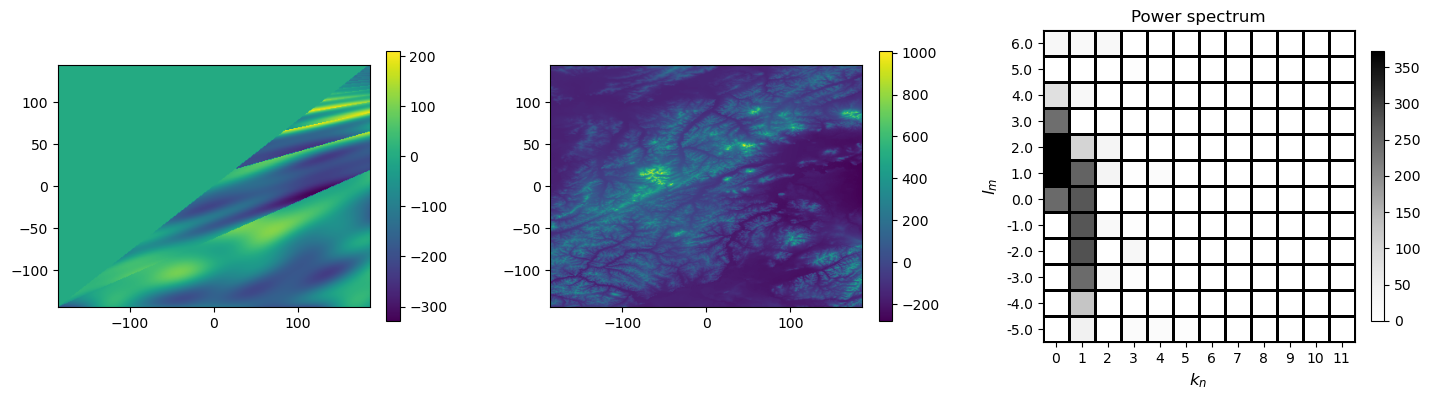

In [127]:
# Setup the Fourier parameters and object.
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)


# For each triangle...
# for idx in range(len(tri.simplices)):
for idx in range(1,2):
    # initialise cell object
    cell = var.topo_cell()
    
    print("computing idx:", idx)
    simplex_lat = circ_tri_lat_verts[idx]
    simplex_lon = circ_tri_lon_verts[idx]

    polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

    init_poly = mask_wrapper(polygon)
    cell.mask = np.array([init_poly(elem) for elem in lat_lon_mgrid]).reshape(topo.lon_grid.shape[0],topo.lon_grid.shape[1]).astype('bool_')

    cell.lat_m = topo.lat_grid[cell.mask]
    cell.lon_m = topo.lon_grid[cell.mask]
    cell.topo_m = topo.topo[cell.mask]
    
    get_lat_lon_segments(tri_lat_verts[idx], tri_lon_verts[idx], cell, topo)
    
    # do fourier...
    fobj.do_full(cell)
    am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.5)
    
    fobj.get_freq_grid(am)
    freqs = np.abs(fobj.ampls)
    
    fq_cpy = np.copy(freqs)

    indices = []
    for _ in range(30):
        max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
        indices.append(max_idx)
        fq_cpy[max_idx] = 0.0

    k_idxs = [pair[1] for pair in indices]
    l_idxs = [pair[0] for pair in indices]
    
    fobj.set_kls(k_idxs, l_idxs)
    fobj.do_full(cell)

    am, data_recons = lin_reg.do(fobj, cell, lmbda = 1e-6)

    fobj.get_freq_grid(am)
    dat_2D = reconstruction.recon_2D(data_recons, cell)

    freqs = np.abs(fobj.ampls)
    
    fs = (18,5)
    fig, axs = plt.subplots(1,3, figsize=fs)
    fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
    axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
    axs[1] = fig_obj.phys_panel(axs[1], cell.topo)
    axs[2] = fig_obj.freq_panel(axs[2], freqs)
    plt.show()

In [126]:
ai = 2.0 * np.abs(np.fft.fft2(cell.topo)) / cell.topo.size

print(ai.max())

119.7654306892361


In [56]:
print(topo.lat_grid[cell.mask].shape)

(1440, 3720)
(1440, 3720)
(53755,)


In [15]:

print(lat_lon_mgrid.shape)

# tf_array = tf_array

print(tf_array.shape)

cell.gen_mgrids()

plt.figure()
plt.contourf(cell.lon_grid, cell.lat_grid, cell.topo*tf_array, vmin=0.0, vmax=2000.0)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(tri_clons, tri_clats, 'o')
plt.show()

(5356800, 2)


NameError: name 'tf_array' is not defined